In [1]:
import pandas as pd 
import numpy as np
import plotly.express as px

train = pd.read_csv('train.csv')
train.head()

test = pd.read_csv('test.csv')
test.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.0,26290,478_0_0,False
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.0,26290,478_0_1,False
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.0,26290,478_0_2,False
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.0,26290,478_0_3,False
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.0,26290,478_0_4,False


In [2]:
# Retrieve the columns of the dataframe
stock_id = train['stock_id']
date_id = train['time_id']
seconds_in_bucket = train['seconds_in_bucket']
imbalance_size = train['imbalance_size']
imbalance_buy_sell_flag = train['imbalance_buy_sell_flag']
reference_price = train['reference_price']
matched_size = train['matched_size']
far_price = train['far_price']
near_price = train['near_price']
bid_price = train['bid_price']
bid_size = train['bid_size']
ask_price = train['ask_price']
ask_size = train['ask_size']
wap = train['wap']
target = train['target']
time_id = train['time_id']
row_id = train['row_id']

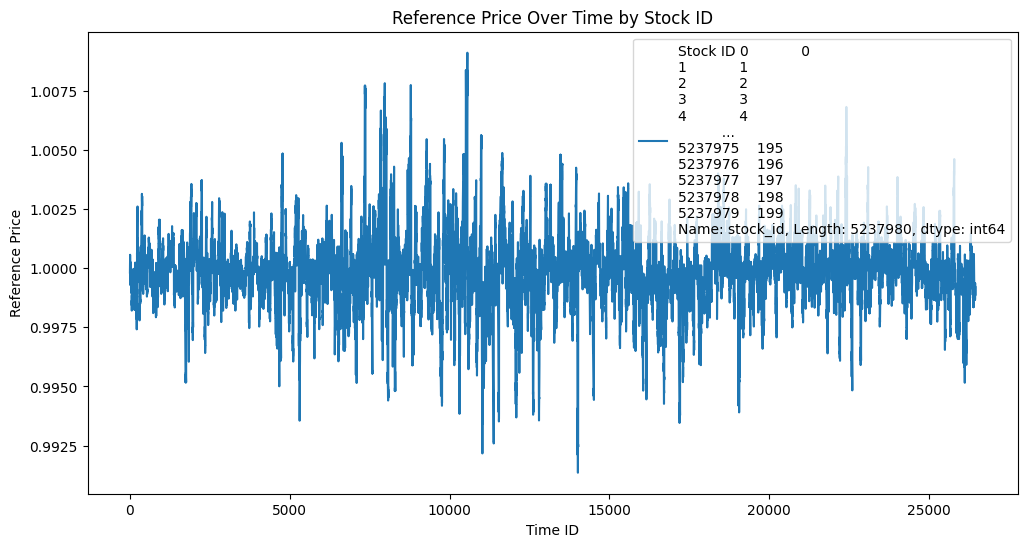

In [3]:
import matplotlib.pyplot as plt

# Plot reference_price over time_id for stock_id = 0
plt.figure(figsize=(12, 6))

stock_data = train[train['stock_id'] == 0]
plt.plot(stock_data['time_id'], stock_data['reference_price'], label=f'Stock ID {stock_id}')

# Add labels and title
plt.xlabel('Time ID')
plt.ylabel('Reference Price')
plt.title('Reference Price Over Time by Stock ID')
plt.legend()

# Show the plot
plt.show()

In [21]:
print(train.dtypes)

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
time_id                      int64
row_id                      object
dtype: object


In [4]:
#
# 1. Data Process

def preprocess_missing_values_advanced(data):
    # Fill independent fields
    data['bid_price'] = data['bid_price'].fillna(data['bid_price'].median())
    data['ask_price'] = data['ask_price'].fillna(data['ask_price'].median())
    data['bid_size'] = data['bid_size'].fillna(0)  # Default to 0 if no bid size
    data['ask_size'] = data['ask_size'].fillna(0)  # Default to 0 if no ask size

    # Compute 'wap' (Weighted Average Price)
    data['wap'] = (
        (data['bid_price'] * data['ask_size'] + data['ask_price'] * data['bid_size']) /
        (data['bid_size'] + data['ask_size'] + 1e-9)  # Avoid division by zero
    )
    data['wap'] = data['wap'].fillna(data['wap'].median())

    # Fill 'far_price' and 'near_price'
    data['far_price'] = data['far_price'].fillna(data['ask_price'])
    data['far_price'] = data['far_price'].fillna(data['reference_price'])
    data['far_price'] = data['far_price'].fillna(data['far_price'].median())

    data['near_price'] = data['near_price'].fillna(data['bid_price'])
    data['near_price'] = data['near_price'].fillna(data['reference_price'])
    data['near_price'] = data['near_price'].fillna(data['near_price'].median())

    # Compute 'imbalance_size'
    data['imbalance_size'] = data['imbalance_size'].fillna(
        (data['bid_size'] + data['ask_size']) - data['matched_size']
    )
    data['imbalance_size'] = data['imbalance_size'].fillna(0)  # Default to 0

    # Compute 'matched_size'
    data['matched_size'] = data['matched_size'].fillna(
        (data['bid_size'] + data['ask_size']) - data['imbalance_size']
    )
    data['matched_size'] = data['matched_size'].fillna(0)  # Default to 0

    # Fill 'reference_price'
    data['reference_price'] = data['reference_price'].fillna(
        data[['near_price', 'far_price']].mean(axis=1)
    )
    data['reference_price'] = data['reference_price'].fillna(data['reference_price'].median())

    # Fill 'target' (only in training data)
    if 'target' in data.columns:
        data['target'] = data['target'].fillna(data['target'].median())

    # Validate no missing values remain
    remaining_missing = data.isnull().sum()
    if remaining_missing.sum() > 0:
        print("Still missing values in the following columns:")
        print(remaining_missing[remaining_missing > 0])
        raise AssertionError("There are still unprocessed missing values!")

    return data

# Drop unnecessary columns
train = train.drop(columns=["row_id"]) 

# Process training and testing datasets
train = preprocess_missing_values_advanced(train)
test = preprocess_missing_values_advanced(test)

# Print results
print("\nMissing Values After Processing (Training Data):")
print(train.isnull().sum())

print("\nMissing Values After Processing (Testing Data):")
print(test.isnull().sum())


Missing Values After Processing (Training Data):
stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
dtype: int64

Missing Values After Processing (Testing Data):
stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
time_id           

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Custom function to calculate MAE
def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# Split data into features and target
X = train.drop(columns=["target", "seconds_in_bucket"])  # feature is added here
y = train["target"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM Overall Model
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1
}
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_test],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

lgb_overall_pred = lgb_model.predict(X_test)

# Get unique time slices
time_slices = train["seconds_in_bucket"].unique()

best_models = {}  # Store the best-performing model for each time slice
slice_results = {}  # Store RMSE values for comparison

for slice_value in time_slices:
    # Filter data for the time slice
    slice_data = train[train["seconds_in_bucket"] == slice_value]
    X_slice = slice_data.drop(columns=["target", "seconds_in_bucket"])
    y_slice = slice_data["target"]

    # Split slice data
    X_slice_train, X_slice_test, y_slice_train, y_slice_test = train_test_split(
        X_slice, y_slice, test_size=0.2, random_state=42
    )

    # LightGBM Slice Model
    lgb_slice_train = lgb.Dataset(X_slice_train, label=y_slice_train)
    lgb_slice_test = lgb.Dataset(X_slice_test, label=y_slice_test, reference=lgb_slice_train)

    lgb_slice_model = lgb.train(
        lgb_params,
        lgb_slice_train,
        num_boost_round=500,
        valid_sets=[lgb_slice_train, lgb_slice_test],
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )
    lgb_slice_pred = lgb_slice_model.predict(X_slice_test)
    overall_slice_pred = lgb_model.predict(X_slice_test)

    # Calculate MAE for the slice model
    lgb_mae = calculate_mae(y_slice_test, lgb_slice_pred)
    overall_mae_lgb = calculate_mae(y_slice_test, overall_slice_pred)

    print(f"Time Slice: {slice_value}, LightGBM MAE: {lgb_mae:.4f}, Overall LightGBM MAE: {overall_mae_lgb:.4f}")

    # Select Best Model for this Slice
    if lgb_mae < overall_mae_lgb:
        best_models[slice_value] = ("LightGBM", lgb_slice_model)
        slice_results[slice_value] = lgb_mae
    else:
        best_models[slice_value] = ("LightGBM Overall", lgb_model)
        slice_results[slice_value] = overall_mae_lgb

# Print the best model and its RMSE for each time slice
for slice_value, (model_name, model) in best_models.items():
    print(f"Best model for slice {slice_value}: {model_name}, MAE: {slice_results[slice_value]:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3262
[LightGBM] [Info] Number of data points in the train set: 4190384, number of used features: 14
[LightGBM] [Info] Start training from score -0.051737
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 9.18929	valid_1's rmse: 9.25397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 76188, number of used features: 14
[LightGBM] [Info] Start training from score -0.083520
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	training's rmse: 10.0326	valid_1's rmse: 10.93

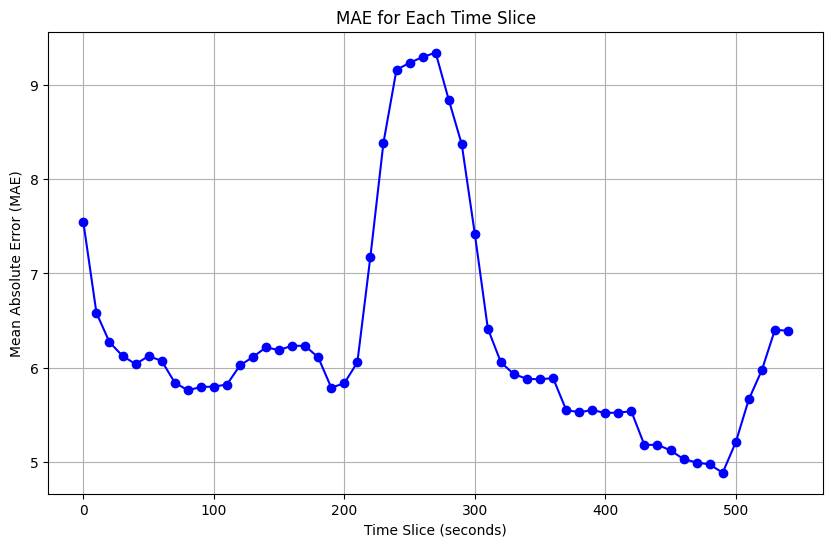

In [12]:
# Ensure time_slices and slice_results have the same length
time_slices = list(slice_results.keys())
mae_values = list(slice_results.values())

plt.figure(figsize=(10, 6))
plt.plot(time_slices, mae_values, marker='o', linestyle='-', color='b')
plt.xlabel('Time Slice (seconds)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE for Each Time Slice')
plt.grid(True)

# Show the plot
plt.show()